# An EDA (Exploratory Data Analysis) for object detection

## 재활용 품목 분류를 위한 Object detection

### Step 0. Importing libraries & prepare DataFrame

In [21]:
import json
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.patches as patches
import pandas as pd
from pycocotools.coco import COCO

### Step 1. Train image analysis

In [2]:
# check the json file
with open('./dataset/train.json', 'r', encoding='utf-8') as f:
	train = json.load(f)

In [3]:
print(train.keys())

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])


- 'info' : metadata
- 'licenses' : 라이선스 정보
- 'images' : 이미지 크기, 이름 등
- 'categories' : 클래스 정보 
- 'annotations' : bbox 좌표, 박스 크기, 단일 객체만 포함되었는지 여부 등

In [4]:
print(train['categories'])

[{'id': 0, 'name': 'General trash', 'supercategory': 'General trash'}, {'id': 1, 'name': 'Paper', 'supercategory': 'Paper'}, {'id': 2, 'name': 'Paper pack', 'supercategory': 'Paper pack'}, {'id': 3, 'name': 'Metal', 'supercategory': 'Metal'}, {'id': 4, 'name': 'Glass', 'supercategory': 'Glass'}, {'id': 5, 'name': 'Plastic', 'supercategory': 'Plastic'}, {'id': 6, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'}, {'id': 7, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'}, {'id': 8, 'name': 'Battery', 'supercategory': 'Battery'}, {'id': 9, 'name': 'Clothing', 'supercategory': 'Clothing'}]


- 위와 같이 10개 클래스가 있음

In [5]:
len(train['images'])  

4883

- train image는 4883개

In [6]:
# 이미지 크기 체크
heights = [x['height'] for x in train['images']]
widths = [x['width'] for x in train['images']]

Text(0, 0.5, 'frequency')

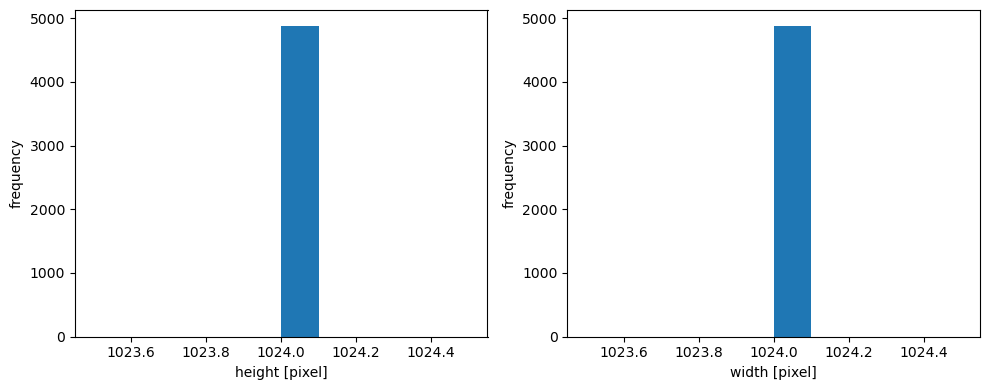

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
ax[0].hist(heights)
ax[0].set_xlabel('height [pixel]')
ax[0].set_ylabel('frequency')
ax[1].hist(widths)
ax[1].set_xlabel('width [pixel]')
ax[1].set_ylabel('frequency')

In [8]:
width, height = set(widths), set(heights)
print(width, height)

{1024} {1024}


- 4883개 모든 이미지가 1024 $\times$ 1024 크기이다.

In [9]:
# bounding box의 개수 체크
print(len(train['annotations']))

23144


- 4883개의 학습 이미지에는 23144개의 bounding box (=쓰레기 객체)가 포함되어 있다.

### Bounding box analysis

In [10]:
# convert json dictionary to pandas DataFrame
coco = COCO('./dataset/train.json')

train_df = pd.DataFrame()

image_ids = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
widths = []
heights = []

for image_id in coco.getImgIds():
        
    image_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_info['id'])
    anns = coco.loadAnns(ann_ids)
        
    file_name = image_info['file_name']
        
    for ann in anns:
        image_ids.append(file_name)
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))
        widths.append(float(ann['bbox'][2]))
        heights.append(float(ann['bbox'][3]))
                    
train_df['image_id'] = image_ids
train_df['class_id'] = class_id
train_df['x_min'] = x_min
train_df['y_min'] = y_min
train_df['x_max'] = x_max
train_df['y_max'] = y_max
train_df['width'] = widths
train_df['height'] = heights

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [12]:
# 한 이미지에 얼마나 많은 bounding box들이 있을까?
count_bbox = train_df.image_id.value_counts()

Text(0, 0.5, 'frequency')

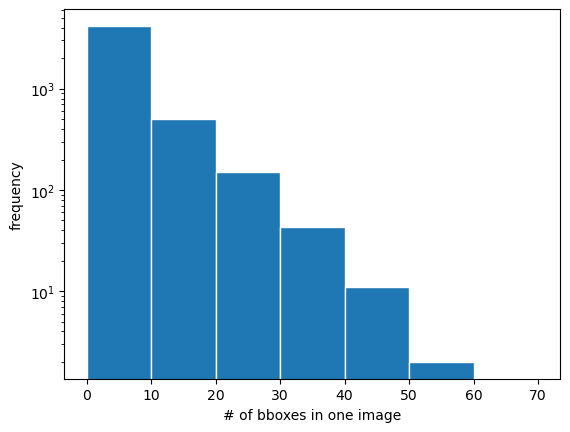

In [13]:
plt.hist(count_bbox, bins=np.arange(0, 80, 10), ec='white')
plt.yscale('log')
plt.xlabel('# of bboxes in one image')
plt.ylabel('frequency')

-  한 이미지 내에 bbox가 많다!

In [14]:
has_one = count_bbox[count_bbox==1]
has_two = count_bbox[count_bbox==2]
has_three = count_bbox[count_bbox==3]
has_four = count_bbox[count_bbox==4]
has_five = count_bbox[count_bbox>=5]    # over five

Text(0.5, 1.0, 'number of bboxes in one image')

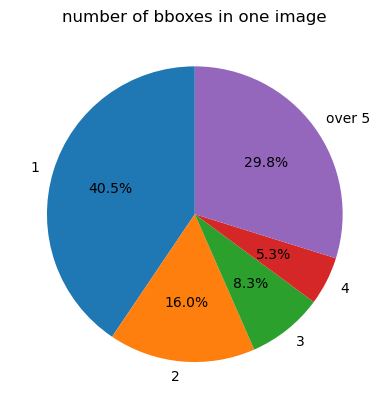

In [15]:
labels = ['1', '2', '3', '4', 'over 5']
num_of_bbox = [len(has_one)/len(train['images'])*100, len(has_two)/len(train['images'])*100, len(has_three)/len(train['images'])*100,
       len(has_four)/len(train['images'])*100, len(has_five)/len(train['images'])*100]

fig, ax = plt.subplots()
ax.pie(num_of_bbox,labels=labels, autopct='%1.1f%%', startangle=90)  
plt.title('number of bboxes in one image')

- 대부분(40.5%)의 이미지들이 bbox를 1개 포함하고 있다.
- 5개 이상의 bbox를 가진 이미지도 ~30%나 된다.

Text(0, 0.5, 'frequency')

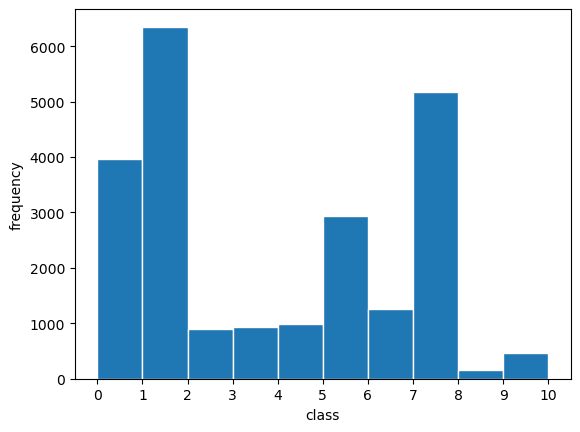

In [16]:
# class imbalance 체크
plt.hist(train_df['class_id'], bins=np.arange(0, 11, 1), ec='white')
plt.xticks(np.arange(0, 11, 1))
plt.xlabel('class')
plt.ylabel('frequency')

- class imbalance가 보임
- 일반 쓰레기, 종이, 플라스틱, 비닐봉지는 상대적으로 많지만 그 외 (종이팩, 철, 유리, 스티로폼, 배터리, 의류)는 수가 적음

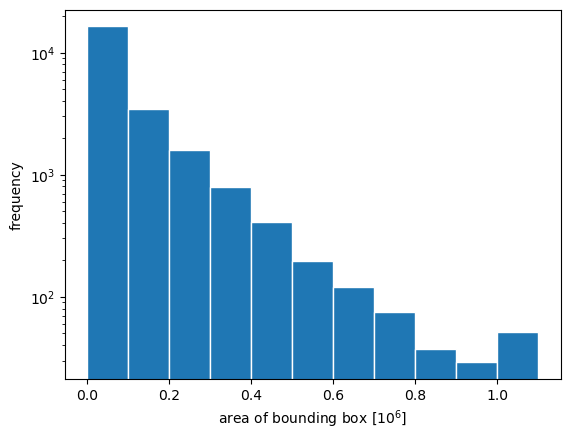

In [20]:
# bbox area distribution
area = train_df['width']*train_df['height']
area1 = [x/10**6 for x in area]

plt.hist(area1, bins=np.arange(0, 1.2, 0.1), ec='white')
plt.xlabel('area of bounding box [$10^6$]')
plt.ylabel('frequency')
plt.yscale('log')

In [92]:
# 이미지와 bbox를 눈으로 확인해보자
img43 = Image.open('./dataset/train/0043.jpg')
img43_list = [x for x in train['annotations'] if x['image_id']==43]

In [100]:
def draw_bbox(xmin, ymin, width, height, label, color='red'):
    #import matplotlib.patches as patches
    bbox = patches.Rectangle((xmin, ymin), width, height, ec=color, fc='none', lw=2, label=label)
    plt.gca().add_patch(bbox)

In [105]:
def num_to_label(num):
    return train['categories'][num]['name']

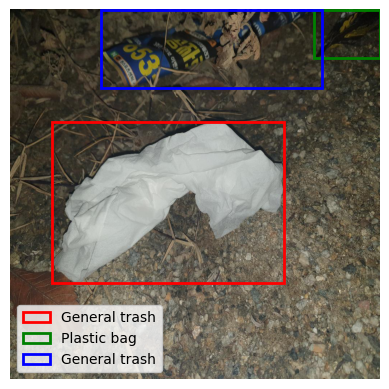

In [106]:
plt.imshow(img43)
plt.axis('off')
colors = ['red', 'green', 'blue']
for i, x in enumerate(img43_list):
    draw_bbox(x['bbox'][0], x['bbox'][1], x['bbox'][2], x['bbox'][3], label=num_to_label(x['category_id']), color=colors[i])
plt.legend()